In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment tools
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk

In [108]:
# import file and convert into dataframe
file_path = 'feedback.xlsx'  
df = pd.read_excel(file_path)

# Show first rows
display(df.head(5))

# Quick check for missing values in the Feedback column
if 'Feedback' in df.columns:
    print("\nMissing values in 'Feedback':", df['Feedback'].isna().sum())
else:
    raise KeyError("No column named 'Feedback' found. Please check your Excel file.")


,Feedback
0,The sound quality was amazing and the movie wa...
1,Seats were uncomfortable and too close together
2,Staff were very friendly and helpful
3,The popcorn was stale and overpriced
4,"I love the new reclining chairs, very comfortable"



Missing values in 'Feedback': 0


In [109]:
# show dataframe shape
df.shape

(122, 1)

In [110]:
# Create a cleaned version of the Feedback column for processing - remove extra spaces and tabs
df['feedback_raw'] = df['Feedback'].astype(str)
df['feedback_clean'] = df['feedback_raw'].str.strip().str.replace(r'\s+', ' ', regex=True).str.lower()

#cleaned df
display(df[['feedback_raw','feedback_clean']].head(5))

,feedback_raw,feedback_clean
0,The sound quality was amazing and the movie wa...,the sound quality was amazing and the movie wa...
1,Seats were uncomfortable and too close together,seats were uncomfortable and too close together
2,Staff were very friendly and helpful,staff were very friendly and helpful
3,The popcorn was stale and overpriced,the popcorn was stale and overpriced
4,"I love the new reclining chairs, very comfortable","i love the new reclining chairs, very comfortable"


In [111]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each feedback entry
df['vader_scores'] = df['feedback_clean'].apply(lambda x: analyzer.polarity_scores(x))

# Expand the dictionary into separate columns
df_vader = pd.json_normalize(df['vader_scores'])
df = pd.concat([df, df_vader], axis=1)

# Drop the intermediate column
df.drop(columns=['vader_scores'], inplace=True)

# Display the updated DataFrame
display(df[['feedback_clean', 'neg', 'neu', 'pos', 'compound']].head(10))

,feedback_clean,neg,neu,pos,compound
0,the sound quality was amazing and the movie wa...,0.000,0.584,0.416,0.7506
1,seats were uncomfortable and too close together,0.302,0.698,0.000,-0.3818
2,staff were very friendly and helpful,0.000,0.379,0.621,0.7620
3,the popcorn was stale and overpriced,0.000,1.000,0.000,0.0000
4,"i love the new reclining chairs, very comfortable",0.000,0.435,0.565,0.8313
5,the theatre was too crowded and noisy,0.221,0.779,0.000,-0.1779
6,"movie started on time, which i really appreciated",0.000,0.661,0.339,0.5563
7,parking was difficult and inconvenient,0.620,0.380,0.000,-0.5994
8,the screen was huge and the picture was perfect,0.000,0.538,0.462,0.7184
9,staff ignored us when we asked for help,0.209,0.545,0.245,0.1027


In [112]:
# classify sentiments based on the compound score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['compound'].apply(classify_sentiment)

# Display results
display(df[['feedback_clean', 'compound', 'sentiment']].head(10))

# Check sentiment counts
print(df['sentiment'].value_counts())

,feedback_clean,compound,sentiment
0,the sound quality was amazing and the movie wa...,0.7506,Positive
1,seats were uncomfortable and too close together,-0.3818,Negative
2,staff were very friendly and helpful,0.7620,Positive
3,the popcorn was stale and overpriced,0.0000,Neutral
4,"i love the new reclining chairs, very comfortable",0.8313,Positive
5,the theatre was too crowded and noisy,-0.1779,Negative
6,"movie started on time, which i really appreciated",0.5563,Positive
7,parking was difficult and inconvenient,-0.5994,Negative
8,the screen was huge and the picture was perfect,0.7184,Positive
9,staff ignored us when we asked for help,0.1027,Positive


sentiment
Positive    61
Neutral     32
Negative    29
Name: count, dtype: int64


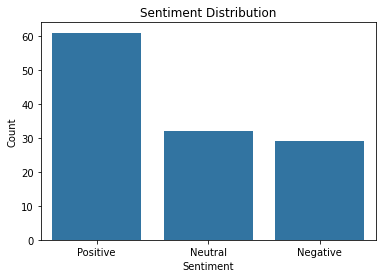

In [113]:
# Bar chart of overall sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [114]:
# Top 5 most negative feedback
print("Most Negative Feedback:")
display(df.sort_values(by='compound', ascending=True).head(5)[['feedback_raw','compound','sentiment']])

# Top 5 most positive feedback
print("\nMost Positive Feedback:")
display(df.sort_values(by='compound', ascending=False).head(5)[['feedback_raw','compound','sentiment']])


Most Negative Feedback:


,feedback_raw,compound,sentiment
80,Staff ignored complaints about broken seats,-0.7964,Negative
51,Bathrooms were dirty and smelled bad,-0.7506,Negative
24,The movie quality was bad due to a blurry proj...,-0.5994,Negative
7,Parking was difficult and inconvenient,-0.5994,Negative
112,The theatre experience was ruined by noisy pat...,-0.5859,Negative



Most Positive Feedback:


,feedback_raw,compound,sentiment
4,"I love the new reclining chairs, very comfortable",0.8313,Positive
38,"Loved the movie experience, very enjoyable",0.7960,Positive
2,Staff were very friendly and helpful,0.7620,Positive
50,I loved the large screen and clear sound,0.7579,Positive
30,I enjoyed the friendly customer service,0.7579,Positive


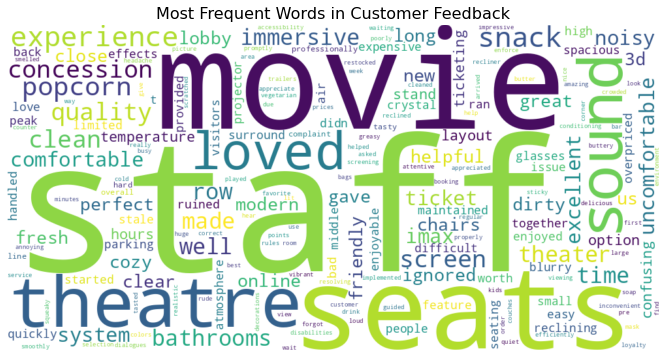

In [122]:
# make a word cloud
from wordcloud import WordCloud

# Combine all cleaned feedback into one big string
all_text = " ".join(df['feedback_clean'].dropna().tolist())

# Create a WordCloud object
wc = WordCloud(
    width=1000,           
    height=500,           
    background_color='white',  
    max_words=200,        # show up to 200 most frequent words
    collocations=False,   # avoid joining words like "coffee_shop" automatically
    contour_color='steelblue', # optional outline color
    contour_width=2
).generate(all_text)

# Plot
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Customer Feedback', fontsize=16)
plt.show()


In [128]:
# subjectivity and polarity analysis
from textblob import TextBlob

# create new columns for polarity and subjectivity scores
df['blob_polarity'] = df['feedback_clean'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['blob_subjectivity'] = df['feedback_clean'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

In [126]:
def subjectivity_meaning(score):
    if score <= 0.3:
        return "Objective / Factual"
    elif score <= 0.6:
        return "Mixed"
    else:
        return "Highly Subjective / Opinionated"

# Apply to create a new column
df['subjectivity_label'] = df['blob_subjectivity'].apply(subjectivity_meaning)

# Display the result
display(df[['feedback_clean', 'blob_polarity', 'blob_subjectivity', 'subjectivity_label']].head(10))


,feedback_clean,blob_polarity,blob_subjectivity,subjectivity_label
0,the sound quality was amazing and the movie wa...,0.366667,0.561111,Mixed
1,seats were uncomfortable and too close together,-0.500000,1.000000,Highly Subjective / Opinionated
2,staff were very friendly and helpful,0.487500,0.650000,Highly Subjective / Opinionated
3,the popcorn was stale and overpriced,-0.500000,0.500000,Mixed
4,"i love the new reclining chairs, very comfortable",0.385455,0.684848,Highly Subjective / Opinionated
5,the theatre was too crowded and noisy,0.000000,0.000000,Objective / Factual
6,"movie started on time, which i really appreciated",0.200000,0.100000,Objective / Factual
7,parking was difficult and inconvenient,-0.550000,1.000000,Highly Subjective / Opinionated
8,the screen was huge and the picture was perfect,0.700000,0.950000,Highly Subjective / Opinionated
9,staff ignored us when we asked for help,0.000000,0.000000,Objective / Factual


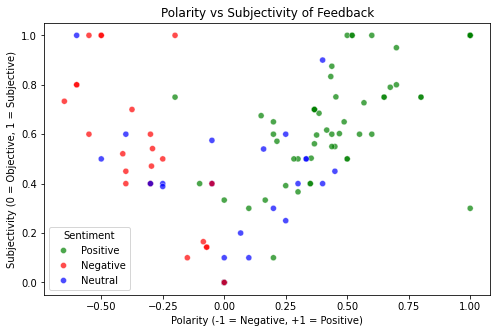

In [129]:
# plot subjectivity and polarity in a scatter plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df, 
    x='blob_polarity', 
    y='blob_subjectivity', 
    hue='sentiment',       # color by sentiment
    palette={'Positive':'green', 'Neutral':'blue', 'Negative':'red'},
    alpha=0.7
)
plt.title('Polarity vs Subjectivity of Feedback')
plt.xlabel('Polarity (-1 = Negative, +1 = Positive)')
plt.ylabel('Subjectivity (0 = Objective, 1 = Subjective)')
plt.legend(title='Sentiment')
plt.show()


In [130]:
from transformers import pipeline

sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    revision="714eb0f"  # optional, you can omit this
)

In [133]:
# Apply Hugging Face sentiment analysis to entire DataFrame
def analyze_sentiment(text):
    result = sentiment_model(str(text))[0]  # get first result
    return pd.Series([result['label'], result['score']])

df[['hf_sentiment_label', 'hf_sentiment_score']] = df['feedback_clean'].apply(analyze_sentiment)


In [134]:
from transformers import pipeline

# Zero-shot classifier
subjectivity_model = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [135]:
candidate_labels = ["subjective", "objective"]


In [136]:
sample_feedback = [
    "Seats were uncomfortable and too close together",
    "The theatre was too crowded and noisy",
    "Loved the IMAX screen and comfortable seats!"
]

for fb in sample_feedback:
    result = subjectivity_model(fb, candidate_labels)
    label = result['labels'][0]         # predicted label
    score = result['scores'][0]         # confidence
    print(f"Feedback: {fb}")
    print(f"Subjectivity: {label}, Confidence: {score:.2f}\n")


Feedback: Seats were uncomfortable and too close together
Subjectivity: subjective, Confidence: 0.63

Feedback: The theatre was too crowded and noisy
Subjectivity: subjective, Confidence: 0.70

Feedback: Loved the IMAX screen and comfortable seats!
Subjectivity: objective, Confidence: 0.75



In [137]:
def analyze_subjectivity(text):
    result = subjectivity_model(str(text), candidate_labels)
    return pd.Series([result['labels'][0], result['scores'][0]])

df[['hf_subjectivity_label', 'hf_subjectivity_score']] = df['feedback_clean'].apply(analyze_subjectivity)


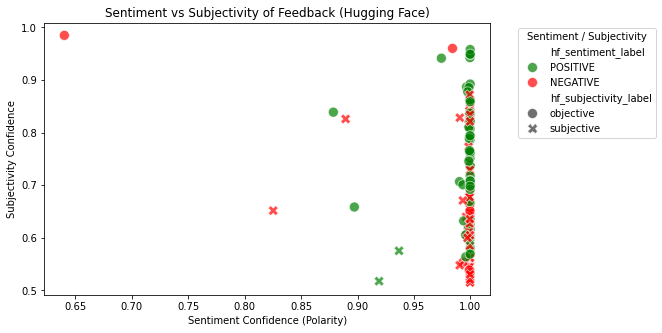

In [139]:
plt.figure(figsize=(8,5))

# Scatter plot using confidence scores for size, color by sentiment
sns.scatterplot(
    data=df,
    x='hf_sentiment_score',           # polarity/confidence
    y='hf_subjectivity_score',        # subjectivity confidence
    hue='hf_sentiment_label',         # color by sentiment
    style='hf_subjectivity_label',    # shape by subjective/objective
    palette={'POSITIVE':'green', 'NEGATIVE':'red', 'NEUTRAL':'blue'},
    alpha=0.7,
    s=100
)

plt.title('Sentiment vs Subjectivity of Feedback (Hugging Face)')
plt.xlabel('Sentiment Confidence (Polarity)')
plt.ylabel('Subjectivity Confidence')
plt.legend(title='Sentiment / Subjectivity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
